### Advantage Actor-Critic (A2C) Agent

> It was previously thought that the combination of simple online reinforcement learning algorithms with deep neural networks was fundamentally unstable. (. . .) \[T\]he sequence of observed data encountered by a online reinforcement learning agent is non-stationary and updates are strongly correlated. By storing the data in an experience replay memory, the data can be batched or randomly sampled from different time steps. Aggregating over memory in this way reduces non-stationarity and decorrelates updates but at the same time limits the methods to off-policy reinforcement learning algorithms. (. . .) In this paper, we provide a very different paradigm for deep reinforcement learning. Instead of experience replay, we asynchronously execute multiple agents in parallel on multiple instances of the environment. This parallelism also decorrelates the data into a more stationary process since at any given time step the parallel agents will be experiencing a variety of different states. This simple idea enables a much larger spectrum of fundamental on-policy reinforcement learning algorithms...
>
> *Asynchronous Methods for Deep Reinforcement Learning*, Mnih et al. (2016)


Advantage Actor-Critic (A2C) is a reinforcement learning algorithm that combines policy gradient methods and value function approximation. The algorithm uses two networks: a `PolicyNetwork` (or actor) and a `ValueNetwork` (or critic). Here, the actor models the policy while the critic estimates the value function to adjust the policy gradient for the actor during training. The algorithm updates both models simultaneously during the training process.

A2C maximizes the expected return by using the advantage function  $A(s_t,a_t)$ to adjust the policy gradient.  
The advantage function is defined as the difference between the return and the baseline value estimated by a value function $V(s_t)$:

$$
A(s_t, a_t) = R_t - V(s_t)
$$

The policy gradient (as previously seen in VPG) is then adjusted as follows:

$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[\sum_{t=0}^T \log \pi_\theta(a_t \mid s_t) \cdot A(s_t, a_t)\right]
$$

In the following implementation, advantages are computed in `Agent.compute_gae_advantages`:

```python
deltas = rewards + self.gamma * torch.cat([values[1:], torch.zeros(1)]) - values

advantage = 0
advantages = torch.zeros_like(deltas)
    for t in reversed(range(len(deltas))):
        advantage = deltas[t] + self.gamma * self.lambda_GAE * advantage
        advantages[t] = advantage
```

Observe that advantages are calculated using state values generated by the value network.

These advantages are then used to update the policy in `Agent.learn`:

```python
policy_loss = -(log_probs * advantages).mean()
self.optimizer_policy.zero_grad()
policy_loss.backward()
self.optimizer_policy.step()
```

The value network is updated simultaneously:

```python
value_loss = F.mse_loss(V_predicted, V_targets)
self.optimizer_policy.zero_grad()
value_loss.backward()
self.optimizer_policy.step()
```

In practice, A2C leverages multiple parallel environments to sample trajectories in a non-sequential manner:

```python
n_envs = 4
env_fns = [lambda: gym.make("LunarLander-v2") for _ in range(n_envs)]
envs = SyncVectorEnv(env_fns)

n_trajectories = 1000 // n_envs
for i in range(n_trajectories + 1):

    . . .

    T = 1000
    for t in range(T):

        . . .

        for j in range(n_envs):

            . . .

```

---


The full implementation is below.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    """ A Parameterized Policy Network π_θ:
     
        A feedforward neural network that represents a parameterized policy. 
        It maps observations to a probability distribution over a discrete action space.

        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_action_dim (int): The dimensionality of the action space.
            n_hidden_dim (int, optional): The number of nodes in the hidden layer. Default is 128.

    """

    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=128, n_hidden_2_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        self.fc3 = nn.Linear(n_hidden_2_dim, n_action_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class ValueNetwork(nn.Module):
    """ A Value Network:
    
       A feedforward neural network that models the state-value function.

        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_hidden_1_dim (int, optional): The number of nodes in hidden layer #1. Default is 128.
            n_hidden_2_dim (int, optional): The number of nodes in hidden layer #2. Default is 128.
    
    """

    def __init__(self, n_obs_dim: int, n_hidden_1_dim=128, n_hidden_2_dim=128):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)
        self.fc3 = nn.Linear(n_hidden_2_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [2]:
from torch.distributions import Categorical
import numpy as np

class Agent:
    """ An Advantage Actor Critic (A2C) Agent:
     
        Args:
            n_obs_dim (int): The dimensionality of the observation space.
            n_action_dim (int): The dimensionality of the action space.
            alpha (float, optional): Learning Rate. Default is 1e-3.
            gamma (float, optional): Discount Factor. Default is 0.95.
            lambda_GAE (float, optional): GAE Coefficient. Default is 0.9.
            entropy_regularization_coefficient (float, optional): Entropy Regularization Coefficient. Default is 1e-2.

        Attributes:
            alpha (float): Learning Rate.
            gamma (float): Discount Factor.
            lambda_GAE (float): GAE Coefficient.
            entropy_regularization_coefficient (float): Entropy Regularization Coefficient.
            policy (PolicyNetwork): Parameterized Policy Network π_θ.
            value (ValueNetwork): Value Network.
            optimizer_policy (torch.optim.Optimizer): Optimizer for Policy.
            optimizer_value (torch.optim.Optimizer): Optimizer for Value.
            eps (float): Machine Epsilon.

        Methods:
            
            act(state: np.ndarray) -> tuple[int, torch.Tensor, torch.Tensor]:
                Samples an action for the given state using the current policy π_θ.

            compute_td_error(rewards: torch.Tensor, values: torch.Tensor) -> torch.Tensor:
                Computes the Temporal Difference (TD) error.

            compute_gae_advantages(deltas: torch.Tensor) -> torch.Tensor:
                Computes Generalized Advantage Estimation (GAE) advantages.

            learn(self, states: list[np.ndarray], actions: list[int], rewards: list[float], next_states: list[np.ndarray], dones: list[bool]) -> float:
                Perform a policy update (and update the value function).
    
    """
    
    def __init__(self, obs_space: int, act_space: int, alpha=1e-3, gamma=0.99, lambda_GAE=0.9, entropy_regularization_coefficient=1e-2):
       
        # set hyperparameters
        self.alpha = alpha              # learning rate
        self.gamma = gamma              # discount factor
        self.lambda_GAE = lambda_GAE    # GAE coefficient

        # for entropy regularization
        self.entropy_regularization_coefficient = entropy_regularization_coefficient

        self.actor = PolicyNetwork(obs_space, act_space)
        self.critic = ValueNetwork(obs_space)

        self.optimizer_policy = torch.optim.AdamW(self.actor.parameters(), lr=self.alpha)
        self.optimizer_value = torch.optim.AdamW(self.critic.parameters(), lr=self.alpha)

        self.eps = np.finfo(np.float32).eps.item() # utility: machine epsilon

    def act(self, state: np.ndarray) -> tuple[int, torch.Tensor, torch.Tensor]:
        """
            Samples an action for the given state using the current parameterized policy π_θ

            Args:
                state (np.ndarray): An observation.

            Returns: 
                int: The sampled action.
                torch.Tensor: The corresponding log probability.
                torch.Tensor: The entropy of the action distribution.
        
        """
        state = torch.from_numpy(state).float().unsqueeze(0)

        dist = Categorical(self.actor(state))
        action = dist.sample() 
        
        return action.item(), dist.log_prob(action), dist.entropy()
    
    def compute_td_error(self, rewards, values):
        """
            Computes Temporal Difference (TD) errors.

            Args:
                rewards (torch.Tensor): List of rewards.
                values (torch.Tensor): List of values.

            Returns:
                torch.Tensor: The TD errors.
        """
        deltas = rewards + self.gamma * torch.cat([values[1:], torch.zeros(1)]) - values
        return deltas
    
    def compute_gae_advantages(self, deltas):
        """
            Computes Generalized Advantage Estimation (GAE) advantages.

            Args:
                deltas (torch.Tensor): The TD errors.

            Returns:
                torch.Tensor: The computed GAE advantages.
        """
        advantage = 0
        advantages = torch.zeros_like(deltas)
        for t in reversed(range(len(deltas))):
            advantage = deltas[t] + self.gamma * self.lambda_GAE * advantage
            advantages[t] = advantage
        return advantages
    
    def learn(self, states: list[np.ndarray], actions: list[int], rewards: list[float], next_states: list[np.ndarray], dones: list[bool]) -> float:
        """
            Perform a policy update (and update the value function).

            Args:
                states (list[np.ndarray]): List of states.
                actions (list[int]): List of actions taken.
                rewards (list[float]): List of rewards received.
                next_states (list[np.ndarray]): List of next states.
                dones (list[bool]): List of done flags indicating if the episode has ended.

            Returns:
                float: The computed policy loss.
        """

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32)

        # normalize rewards
        reward_mean = rewards.mean()
        reward_std = rewards.std()
        rewards = (rewards - reward_mean) / (reward_std + self.eps)

        with torch.no_grad():
            value_targets_next = self.critic(next_states).squeeze()
            value_targets = rewards + (1 - dones) * self.gamma * value_targets_next
            value_predicted = self.critic(states).squeeze()

        # compute advantages
        deltas = self.compute_td_error(rewards, value_predicted)
        advantages = self.compute_gae_advantages(deltas).detach()

        dist = Categorical(self.actor(states))
        log_probs = dist.log_prob(actions)

        # compute policy loss
        policy_loss = -(log_probs * advantages).mean()

        # compute value loss
        value_loss = F.mse_loss(value_predicted, value_targets)

        # entropy regularization
        entropy_loss = dist.entropy().mean()
        policy_loss -= self.entropy_regularization_coefficient * entropy_loss

        # backpropagation

        self.optimizer_policy.zero_grad()
        policy_loss.backward()
        self.optimizer_policy.step()

        self.optimizer_value.zero_grad()
        value_loss.backward()
        self.optimizer_value.step()

        return policy_loss.item()


In [3]:
import gymnasium as gym

# initialize environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f'LunarLander-v2 Environment')
print(f' Observation Space:', obs_space)
print(f' Action Space:', act_space)

LunarLander-v2 Environment
 Observation Space: 8
 Action Space: 4


In [4]:
from gymnasium.vector import SyncVectorEnv
import imageio

# initialize agent
agent = Agent(obs_space, act_space)

n_envs = 5
env_fns = [lambda: env] + [lambda: gym.make("LunarLander-v2") for _ in range(n_envs-1)]
envs = SyncVectorEnv(env_fns) # note: parallel environments

n_average = 10
loss_hist = []
reward_hist = []

frames = []

n_trajectories = 1500 // n_envs
for i in range(n_trajectories + 1):

    states = envs.reset()[0]
    
    traj_states = []
    traj_actions = []
    traj_rewards = []
    traj_next_states = []
    traj_dones = []

    total_rewards = np.zeros(n_envs)
    done = np.zeros(n_envs, dtype=bool)

    T = 1000
    for t in range(T):

        if i % (n_average * 2.5) == 0:
            frame = env.render()
            frames.append(frame)
        
        actions = [agent.act(state)[0] for state in states]
        next_states, rewards, terminated, truncated, _ = envs.step(actions)
        done = done | terminated | truncated
        
        for j in range(n_envs):

            if not done[j]:
                traj_states.append(states[j])
                traj_actions.append(actions[j])
                traj_rewards.append(rewards[j])
                traj_next_states.append(next_states[j])
                traj_dones.append(done[j])
                
                total_rewards[j] += rewards[j]
        
        states = next_states

        if np.all(done):
            break

    traj_states = np.array(traj_states)
    traj_actions = np.array(traj_actions)
    traj_rewards = np.array(traj_rewards)
    traj_next_states = np.array(traj_next_states)
    traj_dones = np.array(traj_dones)

    loss = agent.learn(traj_states, traj_actions, traj_rewards, traj_next_states, traj_dones)
    
    reward_hist.append(total_rewards.mean())
    loss_hist.append(loss)

    if i % n_average == 0:
        avg_loss = np.mean(loss_hist[max(0, i-n_average):(i+1)])
        avg_reward = np.mean(reward_hist[max(0, i-n_average):(i+1)])
        print(f"Episode: {i}/{n_trajectories} | Average Reward: {avg_reward:3.4f} | Average Loss: {avg_loss:3.4f}")

Episode: 0/300 | Average Reward: -101.5130 | Average Loss: -0.0465
Episode: 10/300 | Average Reward: -69.8442 | Average Loss: -0.0406
Episode: 20/300 | Average Reward: -91.2228 | Average Loss: -0.0583
Episode: 30/300 | Average Reward: -104.0735 | Average Loss: -0.0651
Episode: 40/300 | Average Reward: -117.5941 | Average Loss: -0.0572
Episode: 50/300 | Average Reward: -78.6702 | Average Loss: -0.1157
Episode: 60/300 | Average Reward: -121.3010 | Average Loss: -0.0833
Episode: 70/300 | Average Reward: -131.7784 | Average Loss: -0.0382
Episode: 80/300 | Average Reward: -57.1920 | Average Loss: -0.1366
Episode: 90/300 | Average Reward: -67.8595 | Average Loss: -0.1462
Episode: 100/300 | Average Reward: -55.5453 | Average Loss: -0.1789
Episode: 110/300 | Average Reward: -41.5110 | Average Loss: -0.0346
Episode: 120/300 | Average Reward: -22.5764 | Average Loss: 0.0602
Episode: 130/300 | Average Reward: -12.1238 | Average Loss: 0.0699
Episode: 140/300 | Average Reward: 3.3624 | Average Loss

In [5]:
# save
torch.save(agent.policy.state_dict(), 'A2C.pth')

In [6]:
imageio.mimsave('./GIF/A2C.GIF', frames, fps=45)

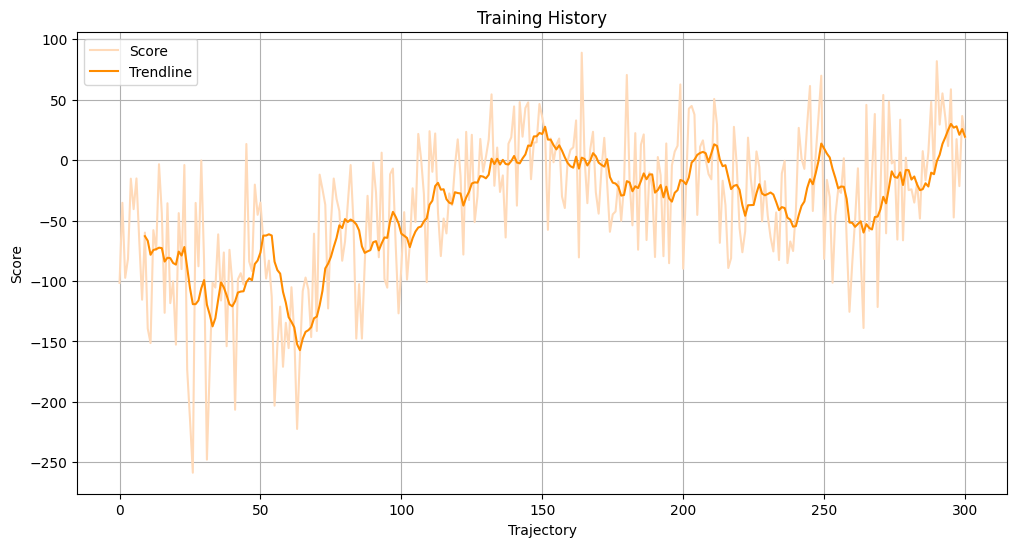

In [7]:
import matplotlib.pyplot as plt

trendline = np.convolve(reward_hist, np.ones(n_average)/n_average, mode='valid')

# plot results
plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color='#FFDAB9')
plt.plot(range(n_average-1, len(reward_hist)), trendline, label='Trendline', color='#FF8C00')
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()